In [109]:
import pandas as pd
from graph_tool import centrality, spectral, clustering

import seaborn as sns
import netpixi

from netpixi.integration.gt import *
from regression.integration.gt import *

df = pd.read_csv("books_1.Best_Books_Ever.csv")
df

,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,...,publishDate,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,bbeScore,bbeVotes,price
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9.78044E+12,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,...,09/14/08,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",2993816,30516,5.09
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9.78044E+12,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,...,09/28/04,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,2632233,26923,7.38
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,1E+13,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",Paperback,...,05/23/06,07-11-1960,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",2269402,23328,NaN
3,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,1E+13,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",Paperback,...,10-10-2000,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",1983116,20452,NaN
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9.78032E+12,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,...,09-06-2006,10-05-2005,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",1459448,14874,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52473,Fractured,Fateful #2,Cheri Schmidt (Goodreads Author),4.00,The Fateful Trilogy continues with Fractured. ...,English,2.94001E+12,"['Vampires', 'Paranormal', 'Young Adult', 'Rom...",[],Nook,...,May 28th 2011,NaN,[],871,"['311', '310', '197', '42', '11']",94.0,[],0,1,NaN
52474,Anasazi,Sense of Truth #2,Emma Michaels,4.19,"'Anasazi', sequel to 'The Thirteenth Chime' by...",English,1E+13,"['Mystery', 'Young Adult']",[],Paperback,...,August 5th 2011,August 3rd 2011,[],37,"['16', '14', '5', '2', '0']",95.0,[],0,1,NaN
52475,Marked,Soul Guardians #1,Kim Richardson (Goodreads Author),3.70,--READERS FAVORITE AWARDS WINNER 2011--Sixteen...,English,9.78146E+12,"['Fantasy', 'Young Adult', 'Paranormal', 'Ange...",[],Paperback,...,March 18th 2011,March 15th 2011,"[""Readers' Favorite Book Award (2011)""]",6674,"['2109', '1868', '1660', '647', '390']",84.0,[],0,1,7.37
52476,Wayward Son,NaN,"Tom Pollack (Goodreads Author), John Loftus (G...",3.85,A POWERFUL TREMOR UNEARTHS AN ANCIENT SECRETBu...,English,9.78145E+12,"['Fiction', 'Mystery', 'Historical Fiction', '...",[],Paperback,...,September 1st 2011,April 5th 2011,[],238,"['77', '78', '59', '19', '5']",90.0,[],0,1,2.86


In [110]:
#df = df.drop(df[df["numRatings"] < 10000].index)

In [111]:
df_cols = df.loc[:, ("title", "rating", "genres", "series", "numRatings")]
df_cols

,title,rating,genres,series,numRatings
0,The Hunger Games,4.33,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",The Hunger Games #1,6376780
1,Harry Potter and the Order of the Phoenix,4.50,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",Harry Potter #5,2507623
2,To Kill a Mockingbird,4.28,"['Classics', 'Fiction', 'Historical Fiction', ...",To Kill a Mockingbird,4501075
3,Pride and Prejudice,4.26,"['Classics', 'Fiction', 'Romance', 'Historical...",NaN,2998241
4,Twilight,3.60,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",The Twilight Saga #1,4964519
...,...,...,...,...,...
52473,Fractured,4.00,"['Vampires', 'Paranormal', 'Young Adult', 'Rom...",Fateful #2,871
52474,Anasazi,4.19,"['Mystery', 'Young Adult']",Sense of Truth #2,37
52475,Marked,3.70,"['Fantasy', 'Young Adult', 'Paranormal', 'Ange...",Soul Guardians #1,6674
52476,Wayward Son,3.85,"['Fiction', 'Mystery', 'Historical Fiction', '...",NaN,238


In [112]:
teste = df_cols.loc[0, "genres"]

def para_lista(string):
    return string[2:-2].split("', '")

para_lista(teste)
    

['Young Adult',
 'Fiction',
 'Dystopia',
 'Fantasy',
 'Science Fiction',
 'Romance',
 'Adventure',
 'Teen',
 'Post Apocalyptic',
 'Action']

In [113]:
df_cols["genres"] = df_cols["genres"].apply(para_lista)

df_cols

,title,rating,genres,series,numRatings
0,The Hunger Games,4.33,"[Young Adult, Fiction, Dystopia, Fantasy, Scie...",The Hunger Games #1,6376780
1,Harry Potter and the Order of the Phoenix,4.50,"[Fantasy, Young Adult, Fiction, Magic, Childre...",Harry Potter #5,2507623
2,To Kill a Mockingbird,4.28,"[Classics, Fiction, Historical Fiction, School...",To Kill a Mockingbird,4501075
3,Pride and Prejudice,4.26,"[Classics, Fiction, Romance, Historical Fictio...",NaN,2998241
4,Twilight,3.60,"[Young Adult, Fantasy, Romance, Vampires, Fict...",The Twilight Saga #1,4964519
...,...,...,...,...,...
52473,Fractured,4.00,"[Vampires, Paranormal, Young Adult, Romance, F...",Fateful #2,871
52474,Anasazi,4.19,"[Mystery, Young Adult]",Sense of Truth #2,37
52475,Marked,3.70,"[Fantasy, Young Adult, Paranormal, Angels, Rom...",Soul Guardians #1,6674
52476,Wayward Son,3.85,"[Fiction, Mystery, Historical Fiction, Adventu...",NaN,238


In [114]:
df_sorted = df_cols.sort_values(by='rating', ascending=False)

df_sorted

,title,rating,genres,series,numRatings
20316,Mind Games (Southern Psychic Sisters),5.0,[],NaN,1
23563,Spifford Max and the Cycle Pups Go to Washingt...,5.0,[],NaN,1
32299,Oftalmologjia,5.0,[],NaN,7
37250,Aleja's Beautiful Poetic Strategy in Recovery,5.0,[],NaN,2
23539,Everyday A**holes: Drawings By Dean Blake,5.0,[],NaN,8
...,...,...,...,...,...
33659,Heitere Verse - Von Menschen und Unmenschen,0.0,[],NaN,0
26062,Illumination Idyllic Comfort To Opt,0.0,[],NaN,0
41746,"How to Disappear: From Abusive Spouses, Bloodh...",0.0,[],NaN,0
28472,giveaways,0.0,[],NaN,0


In [115]:
df_filtered = df_sorted[~df_sorted['genres'].apply(lambda x: len(x) == 1 and x[0] == '')]

df_filtered

,title,rating,genres,series,numRatings
20937,Bertie's Book of Spooky Wonders,5.00,"[Middle Grade, Fantasy]",NaN,4
42586,A Dispensational Theology,5.00,[Theology],NaN,6
20987,Ποιήματα 1943-1987,5.00,[Poetry],NaN,5
32454,Why Are You a Vegan? and Other Wacky Verse for...,5.00,[Poetry],NaN,11
43018,Here Before Kilroy,5.00,[Fiction],NaN,2
...,...,...,...,...,...
20845,Skull Flowers,2.48,"[Fantasy, Science Fiction, Young Adult, Cyberp...",NaN,112
13075,Dianetics: The Modern Science of Mental Health,2.39,"[Religion, Nonfiction, Philosophy, Psychology,...",NaN,2889
51200,Waiting For Kate Bush,2.25,[Music],NaN,60
5752,Revealing Eden,1.99,"[Young Adult, Dystopia, Science Fiction, Fanta...",Save the Pearls #1,917


In [116]:
df_sampled = df_filtered.sample(n=2000, random_state=27)

df_sampled

,title,rating,genres,series,numRatings
7326,What the Dog Saw and Other Adventures,3.85,"[Nonfiction, Psychology, Business, Essays, Soc...",NaN,89300
3288,The City and the Stars,4.09,"[Science Fiction, Fiction, Classics, Dystopia,...",NaN,27880
23075,Nhân Tố Enzyme,4.10,"[Health, Nonfiction, Nutrition, Self Help, Sci...",The Enzyme Factor #1,2481
48526,Storie ancora più impreviste,3.99,"[Short Stories, Fiction, Horror, Fantasy, Humo...",Roald Dahl's Tales of the Unexpected #2,1080
14936,Marathon Man,4.12,"[Fiction, Thriller, Mystery, Crime, Mystery Th...",Babe Levy #1,19544
...,...,...,...,...,...
7085,A Kestrel for a Knave,4.02,"[Fiction, Classics, Animals, British Literatur...",NaN,4813
25447,The Ice Cream Man and Other Stories,4.13,"[Short Stories, Fiction, The United States Of ...",NaN,186
388,The English Patient,3.88,"[Fiction, Historical Fiction, Classics, Romanc...",NaN,113375
2228,Travesuras de la niña mala,4.09,"[Fiction, Romance, Novels, Latin American, Spa...",NaN,29290


In [117]:
g = Graph(directed=False) # não dirigido
lc = clustering.local_clustering(g)
g.add_vp('rating')
g.add_ep('weight')
    
for index, row in df_cols.iterrows():
    vertex = g.add_vertex(index)
    vertex["rating"] = row["rating"]

In [118]:
pares_checados = set()

def dataset_edges(dataset):
    for index1, row1 in dataset.iterrows():
        for index2, row2 in dataset.iloc[index1+1:].iterrows():
            if (index1, index2) in pares_checados or (index2, index1) in pares_checados or index1 == index2:
                continue

            genres_1 = set(row1["genres"])
            genres_2 = set(row2["genres"])
            common_genres = genres_1.intersection(genres_2)
            peso1 = {}
            peso2 = {}
            peso = 0
            for genero in common_genres:
                peso1[genero] = len(genres_1) - list(genres_1).index(genero)
                peso2[genero] = len(genres_2) - list(genres_2).index(genero)
                peso += (peso1[genero] + peso2[genero])/(len(genres_1) + len(genres_2))

            if peso:
                edge = g.add_edge(index1, index2)
                edge["weight"] = peso/len(common_genres)

            pares_checados.add((index1, index2))
    
    

In [119]:
dataset_edges(df_sampled)

In [120]:
#gt_save(g, 'projeto.net.gz')

In [121]:
g = gt_clean(g)

In [122]:
cc = centrality.closeness(g)

In [123]:
hcc = centrality.closeness(g, harmonic=True)

In [124]:
g.add_vp('closeness', cc)

In [125]:
n = g.num_vertices()
n

1923

In [126]:
m = g.num_edges()
m

68187

In [127]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

1848003

In [128]:
d = m / max_edges
d

0.0368976673739166

In [129]:
data = gt_data(g)
data

,rating,closeness
id,,
0,4.30,0.844464
1,3.88,0.776252
2,4.00,0.824185
3,4.06,0.816483
4,3.98,0.774376
...,...,...
1918,3.90,0.484619
1919,3.84,0.471425
1920,4.12,0.459699


In [130]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

In [131]:
data['degree'] = degrees
data

,rating,closeness,degree
id,,,
0,4.30,0.844464,1592
1,3.88,0.776252,1402
2,4.00,0.824185,1539
3,4.06,0.816483,1514
4,3.98,0.774376,1396
...,...,...,...
1918,3.90,0.484619,6
1919,3.84,0.471425,4
1920,4.12,0.459699,2


count    1923.000000
mean       70.917317
std       187.594236
min         1.000000
25%        12.000000
50%        34.000000
75%        62.000000
max      1592.000000
Name: degree, dtype: float64

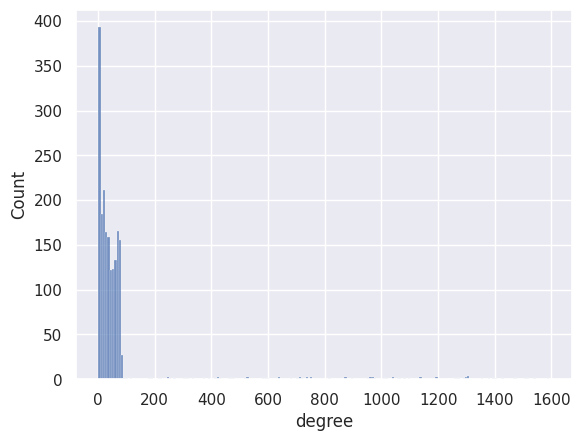

In [132]:
sns.histplot(data['degree'])
data['degree'].describe()

In [133]:
new_data = {'vertice_fonte': [],
        'vertice_alvo': [],
        'peso': []}

for e in g.all_edges():
    #peso.append(e["weight"])
    #data[e[0]]["pesos"].append(e["weight"])
    #data[e[1]]["pesos"].append(e["weight"])
    for key, value in e.items():
        new_data["vertice_fonte"].append(e.get_source().get_id())
        new_data["vertice_alvo"].append(e.get_target().get_id())
        new_data["peso"].append(value)

peso_df = pd.DataFrame(new_data)
peso_df

,vertice_fonte,vertice_alvo,peso
0,0,1481,0.605263
1,0,479,1.000000
2,0,1863,0.250000
3,0,1471,0.300000
4,0,425,0.490000
...,...,...,...
68182,86,300,0.950000
68183,86,941,0.535714
68184,86,19,0.625000
68185,86,103,0.683333


count    68187.000000
mean         0.738085
std          0.196072
min          0.100000
25%          0.600000
50%          0.730000
75%          0.925000
max          1.000000
Name: peso, dtype: float64

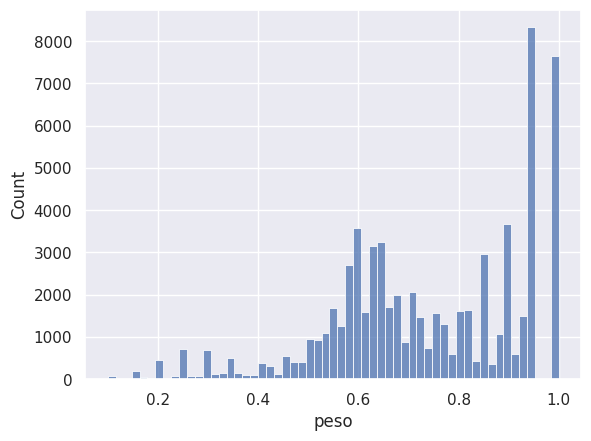

In [134]:
sns.histplot(peso_df['peso'])
peso_df['peso'].describe()

In [135]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'projeto.net.gz')
r = netpixi.render('projeto.net.gz', infinite=True);

In [137]:
r.vertex_scale('closeness', 10, 50)
r.edge_scale('weight', 1, 30)
#r.vertex_scale('rating', 1, 30)